In [1]:
import sqlite3 as sql
import pandas as pd
!pip install xlsxwriter
import xlsxwriter
import xlrd
import openpyxl
from openpyxl import load_workbook
import os
import os.path
from os import path
import datetime as dt
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import csv
pd.options.mode.chained_assignment = None
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir("drive/My Drive") # after you run this once you will get an error if you run again. You can ignore

In [3]:
news_2018 = sql.connect('USML_Project/Data/2018_articles.db')
news_2019=sql.connect('USML_Project/Data/2019_articles.db')
news_2020=sql.connect('USML_Project/Data/2019_articles.db')

In [4]:
frame_2018 = pd.read_sql_query("SELECT * FROM articles where source  LIKE '%Fox%' or source  LIKE '%NBC%' or source  LIKE '%CNN%'", news_2018)


In [5]:
frame_2018['source'] = frame_2018['source'].str.replace('CNBC','NBC')
frame_2018['source'] = frame_2018['source'].str.replace('MSNBC','NBC')

In [6]:
frame_2018

,date,source,name,content
0,2018-02-05,NBC,A 150 tweet by Speaker Ryan raised his challen...,One inexpensive and quickly deleted tweet by...
1,2018-02-05,NBC,After Dow plunges White House says its focused...,The White House said Monday it is worried abou...
2,2018-02-05,NBC,Devin Nunes Trump never met with Papadopoulos ...,Rep. Devin Nunes is the author of a newly decl...
3,2018-02-05,NBC,He must be stopped Trump lashes out at top Dem...,President Donald Trump lashed out at the top D...
4,2018-02-05,NBC,House Intelligence panel votes to release Demo...,The House Intelligence Committee voted Monday ...
...,...,...,...,...
20333,2018-11-30,NBC,Trump cabinet secretary targets House Dem,"Donald Trumps cabinet may be a rogues gallery,..."
20334,2018-11-30,NBC,Trump cancels Putin meeting after Cohen admits...,From Russia with Love: Trump sought business i...
20335,2018-11-30,NBC,Trump tweets he lightly looked at real estate ...,Breaking down the week of Trump blockbusters
20336,2018-11-30,NBC,What does NYT report on TM Landry school say a...,# What does NYT report on TM Landry school say...


In [7]:
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from collections import Counter
import nltk
import time
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Error loading corpus: Package 'corpus' not found in index


False

In [9]:
import re
nltk.download('averaged_perceptron_tagger')
stemmer = PorterStemmer()
import sys 


progress = 0 #for keeping track of where the function is
def stem(x):
    end = time.time()
    dirty = word_tokenize(x)
    tokens = []
    for word in dirty:
        if word.strip('.') == '': #this deals with the bug
           pass
        elif re.search(r'\d{1,}', word): #getting rid of digits
           pass
        else:
           tokens.append(word.strip('.'))
    global start
    global progress
    tokens = pos_tag(tokens) #
    progress += 1
    stems = ' '.join(stemmer.stem(key.lower()) for key, value in  tokens if value != 'NNP') #getting rid of proper nouns
 
    end = time.time()
    sys.stdout.write('\r {} percent, {} position, {} per second '.format(str(float(progress / len(frame_2018))), 
    str(progress), (1 / (end - start)))) #lets us see how much time is left 
    start = time.time()
    return stems
start = time.time()
frame_2018['stems'] = frame_2018.content.apply(lambda x: stem(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
 1.0 percent, 20338 position, 627.4201944652207 per second 

In [10]:
from collections import Counter
all_words = Counter()
start = time.time()
progress = 0
def count_everything(x):
    global start
    global all_words
    global progress
    x = x.split(' ' )
    for word in x:
        all_words[word] += 1
    progress += 1
    end = time.time()
    sys.stdout.write('\r {} percent, {} position, {} per second '.format((str(float(progress / len(frame_2018)))), (progress), (1 / (end - start))))
    start = time.time()
for item in frame_2018.stems:
    count_everything(item)

 1.0 percent, 20338 position, 123361.88235294117 per second 

In [11]:
allwordsdf = pd.DataFrame(columns = ['words', 'count'])
allwordsdf['count'] = pd.Series(list(all_words.values()))
allwordsdf['words'] = pd.Series(list(all_words.keys()))
allwordsdf.index = allwordsdf['words']
allwordsdf.head(20)

,words,count
words,,
one,one,18103
inexpens,inexpens,10
and,and,190077
quickli,quickli,1114
delet,delet,220
tweet,tweet,7097
by,by,38376
is,is,79036
rais,rais,3580


In [12]:
from nltk.corpus import words
nltk.download('words')
nltkstems = [stemmer.stem(word) for word in words.words()] #stem the #words in the NLTK corpus so that they’re equivalent to the words in #the allwordsdf dataframe
nltkwords = pd.DataFrame() #make a new dataframe with the stemmed #NLTK words
nltkwords['words'] = nltkstems
allwordsdf = allwordsdf[allwordsdf['words'].isin(nltkwords['words'])] #keep only #those in the stemmed NLTK corpus


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [13]:
allwordsdf[allwordsdf['count'] == allwordsdf['count'].quantile(.4)][:10]

,words,count
words,,
quantit,quantit,6
sequest,sequest,6
cun,cun,6
sixteen,sixteen,6
militarist,militarist,6
cerebr,cerebr,6
trepid,trepid,6
cylind,cylind,6
softbal,softbal,6


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords = list(allwordsdf[(allwordsdf['count'] >= allwordsdf['count'].quantile(.995)) | (allwordsdf['count'] <= allwordsdf['count'].quantile(.4))]['words'])
vecvocab = list(allwordsdf[(allwordsdf['count'] < allwordsdf['count'].quantile(.995)) & (allwordsdf['count'] > allwordsdf['count'].quantile(.4))]['words'])
vec = TfidfVectorizer(stop_words = stopwords, vocabulary = vecvocab, tokenizer=None)

In [15]:
vec_matrix = vec.fit_transform(frame_2018['stems'].sample(1000))

                               

In [16]:
frame_2018['stems'].shape

(20338,)

In [17]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=vec_matrix.shape[1]-1)
vec_matrix_pca = tsvd.fit_transform(vec_matrix)

In [18]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [19]:
value=select_n_components(tsvd_var_ratios, 0.95)

In [20]:
print("number of componets: ",value)

number of componets:  707


In [21]:
vec_matrix = vec.fit_transform(frame_2018['stems'])

In [22]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=value)
vec_matrix_pca = pca.fit_transform(vec_matrix)

In [23]:

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [24]:
wcss = []
for i in range(1, 30): 
    kmeans = KMeans(n_clusters=i, verbose = 0)
    kmeans.fit(vec_matrix_pca) 
    wcss.append(kmeans.inertia_)

<function matplotlib.pyplot.show>

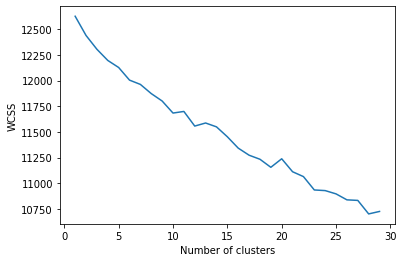

In [25]:
plt.plot(range(1, 30), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show

<function matplotlib.pyplot.show>

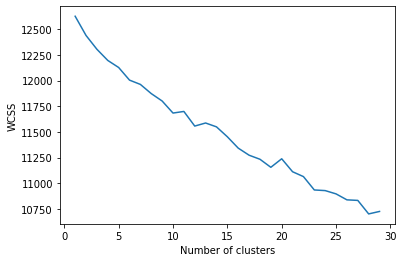

In [26]:
plt.plot(range(1, 30), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show

cross validattion 
spetral clusturing 

In [133]:
kmeans = KMeans(n_clusters = 3, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(vec_matrix_pca)


In [124]:
X=vec_matrix_pca

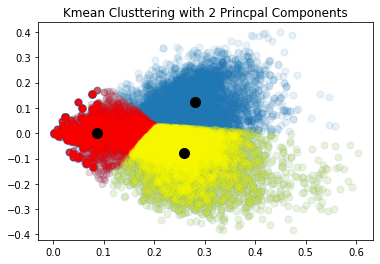

In [141]:
plt.scatter(vec_matrix_pca[:, 0], vec_matrix_pca[:, 1] ,s=50, cmap='viridis',alpha=.1)
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], c = 'red', label = 'Cluster1',alpha=.1)
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], c = 'yellow', label = 'Cluster2',alpha=.1)
#plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], c = 'green', label = 'Cluster3',alpha=.01)
#plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], c = 'violet', label = 'Cluster4',alpha=.01)
#plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], c = 'yellow', label = 'Cluster5',)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')

plt.title("Kmean Clusttering with 2 Princpal Components")
plt.show()

In [31]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
  
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(vec_matrix_pca)

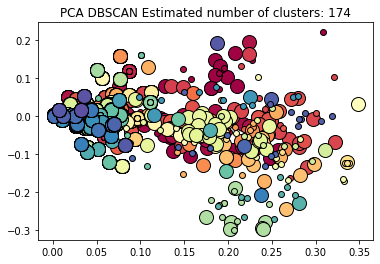

In [130]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    if k != -1:
      class_member_mask = (labels == k)

      xy = X[class_member_mask & core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=14)

      xy = X[class_member_mask & ~core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)

plt.title('PCA DBSCAN Estimated number of clusters: %d' % n_clusters_)
plt.show()


In [33]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(vec_matrix_pca, labels))

Estimated number of clusters: 109
Estimated number of noise points: 17017
Silhouette Coefficient: 0.232


In [34]:
from sklearn.cluster import KMeans
clf10 = KMeans(n_clusters=4, verbose = 0)
clf10.fit(vec_matrix_pca)

KMeans(n_clusters=4)

In [35]:
frame_2018['labels'] = clf10.labels_
frame_2018['index1'] = frame_2018.index

In [36]:
frame_2018

,date,source,name,content,stems,labels,index1
0,2018-02-05,NBC,A 150 tweet by Speaker Ryan raised his challen...,One inexpensive and quickly deleted tweet by...,one inexpens and quickli delet tweet by is rai...,1,0
1,2018-02-05,NBC,After Dow plunges White House says its focused...,The White House said Monday it is worried abou...,the said it is worri about the stock market se...,1,1
2,2018-02-05,NBC,Devin Nunes Trump never met with Papadopoulos ...,Rep. Devin Nunes is the author of a newly decl...,is the author of a newli declassifi document f...,0,2
3,2018-02-05,NBC,He must be stopped Trump lashes out at top Dem...,President Donald Trump lashed out at the top D...,"lash out at the top on the , a day after democ...",0,3
4,2018-02-05,NBC,House Intelligence panel votes to release Demo...,The House Intelligence Committee voted Monday ...,the vote night to releas democrat ' rebutt to ...,2,4
...,...,...,...,...,...,...,...
20333,2018-11-30,NBC,Trump cabinet secretary targets House Dem,"Donald Trumps cabinet may be a rogues gallery,...","cabinet may be a rogu galleri , but stand out ...",1,20333
20334,2018-11-30,NBC,Trump cancels Putin meeting after Cohen admits...,From Russia with Love: Trump sought business i...,from with : sought busi in for year,2,20334
20335,2018-11-30,NBC,Trump tweets he lightly looked at real estate ...,Breaking down the week of Trump blockbusters,break down the week of blockbust,2,20335
20336,2018-11-30,NBC,What does NYT report on TM Landry school say a...,# What does NYT report on TM Landry school say...,# what doe report on school say about the educ...,2,20336


In [37]:
labelsdf = frame_2018.groupby(['source', 'labels']).count()
pubslist = list(frame_2018['source'].unique())
labelsdf['percentage'] = 0
for index, row in labelsdf.iterrows():
    for pub in pubslist:
        for label in range(10):
            try:
                labelsdf.loc[(pub, label), 'percentage'] = labelsdf.loc[(pub, label), 'index1'] / labelsdf.loc[(pub), 'index1'].sum()
            except:
                pass

In [38]:
labelsdf= labelsdf.reset_index()
llabelsdf1=labelsdf[['source', 'labels', 'percentage']]

In [39]:
llabelsdf1

,source,labels,percentage
0,CNN,0,0.246038
1,CNN,1,0.594001
2,CNN,2,0.031822
3,CNN,3,0.128139
4,Fox News,0,0.248229
5,Fox News,1,0.523825
6,Fox News,2,0.028976
7,Fox News,3,0.198970
8,NBC,0,0.092691
9,NBC,1,0.234109


Text(0.5, 0, 'Cluster')

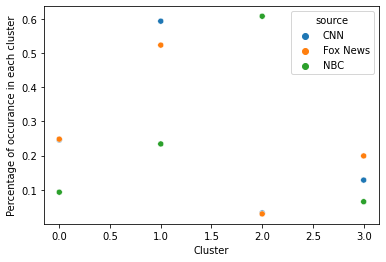

In [40]:
import seaborn
seaborn.scatterplot(x='labels',
                    y='percentage',
                    hue="source",data=llabelsdf1)
plt.ylabel('Percentage of occurance in each cluster')
# Set y-axis label
plt.xlabel('Cluster')

In [41]:
vec_matrix_pca

array([[ 0.17534734, -0.04481743, -0.0098892 , ...,  0.02725756,
         0.02241197, -0.01926747],
       [ 0.13734042, -0.09266193, -0.01289857, ...,  0.04225296,
         0.02190846,  0.00827683],
       [ 0.19477145,  0.12172603,  0.01750263, ...,  0.04124557,
         0.00830066, -0.03432361],
       ...,
       [ 0.03965248, -0.00833287, -0.00251037, ...,  0.03207574,
        -0.01216634,  0.0075367 ],
       [ 0.09192294, -0.00760472,  0.00548873, ..., -0.00408432,
        -0.00299056,  0.01886929],
       [ 0.03965248, -0.00833287, -0.00251037, ...,  0.03207574,
        -0.01216634,  0.0075367 ]])

In [131]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(vec_matrix)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [132]:
tsne_obj

array([[ 10.885931,  27.793226],
       [ 15.690606,  27.79686 ],
       [-60.371845,  -8.063205],
       ...,
       [ 42.203754, -30.08232 ],
       [ 58.347275,  28.70983 ],
       [ 42.203754, -30.08232 ]], dtype=float32)

In [44]:
work= KMeans(n_clusters=3, verbose = 0)
work.fit(tsne_obj)


KMeans(n_clusters=4)

In [45]:
y_kmeans = work.fit_predict(tsne_obj)

In [46]:
x = tsne_obj

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], c = 'red', label = 'Cluster1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], c = 'blue', label = 'Cluster2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], c = 'green', label = 'Cluster3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], c = 'violet', label = 'Cluster4')

#plt.scatter(work.cluster_centers_[:, 0], work.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')


plt.show()

In [48]:
# import neccessaries librariesimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

In [ ]:
# Now check silhouette coefficient
for i,k in enumerate([2,3,4,5]):
    
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # Run the kmeans algorithm
    km = KMeans(n_clusters=k)
    y_predict = km.fit_predict(vec_matrix_pca)
    centroids  = km.cluster_centers_
silhouette_vals = silhouette_samples(vec_matrix_pca,y_predict)

In [50]:
# silhouette plot
y_ticks = []
y_lower = y_upper = 0
for i,cluster in enumerate(np.unique(y_predict)):
   cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
   cluster_silhouette_vals.sort()
   y_upper += len(cluster_silhouette_vals)
   
   ax[0].barh(range(y_lower,y_upper),
   cluster_silhouette_vals,height =1);
   ax[0].text(-0.03,(y_lower+y_upper)/2,str(i+1))
   y_lower += len(cluster_silhouette_vals)
       
   # Get the average silhouette score 
   avg_score = np.mean(silhouette_vals)
   ax[0].axvline(avg_score,linestyle ='--',
   linewidth =2,color = 'green')
   ax[0].set_yticks([])
   ax[0].set_xlim([-0.1, 1])
   ax[0].set_xlabel('Silhouette coefficient values')
   ax[0].set_ylabel('Cluster labels')
   ax[0].set_title('Silhouette plot for the various clusters');
    
    
    # scatter plot of data colored with labels
   

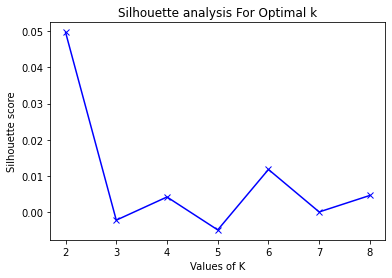

In [51]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(vec_matrix_pca)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(vec_matrix_pca, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [52]:
wcss = []
for i in range(1, 10): 
    kmeans = KMeans(n_clusters=i, verbose = 0)
    kmeans.fit(tsne_obj) 
    wcss.append(kmeans.inertia_)

<function matplotlib.pyplot.show>

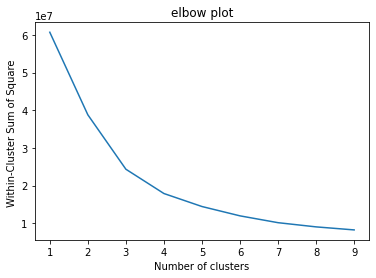

In [117]:
plt.plot(range(1, 10), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square ') 
plt.title("elbow plot")
plt.show

In [54]:
work= KMeans(n_clusters=3, verbose = 0)
work.fit(tsne_obj)


KMeans(n_clusters=3)

In [55]:
y_kmeans = work.fit_predict(tsne_obj)

In [56]:
X = tsne_obj

In [57]:
y_kmeans.shape

(20338,)

In [58]:
work.cluster_centers_

array([[  5.0779686,  42.41758  ],
       [ 33.14793  , -24.304695 ],
       [-40.23599  , -15.463072 ]], dtype=float32)

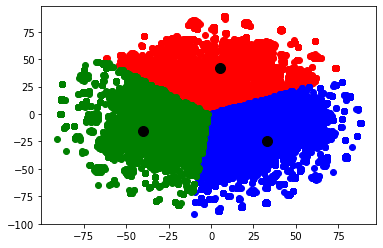

In [100]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], c = 'red', label = 'Cluster1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], c = 'blue', label = 'Cluster2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], c = 'green', label = 'Cluster3')
#plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], c = 'violet', label = 'Cluster4')

#plt.scatter(work.cluster_centers_[:, 0], work.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')


plt.show()

In [114]:
db = DBSCAN(eps=0.3, min_samples=10).fit(tsne_obj)

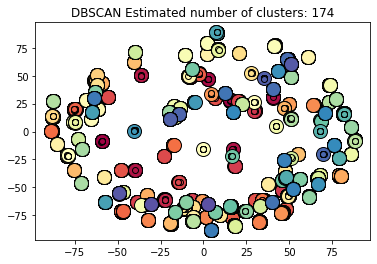

In [115]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    if k != -1:
      class_member_mask = (labels == k)

      xy = X[class_member_mask & core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=14)

      xy = X[class_member_mask & ~core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)

plt.title('DBSCAN Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [62]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(vec_matrix_pca, labels))

Estimated number of clusters: 174
Estimated number of noise points: 17211
Silhouette Coefficient: 0.017


#chekcing on different dimensions 

In [65]:
from sklearn.manifold import TSNE
component_list = [2, 3, 50, 100, 200]
explained_variance_lis=[0]*5
singular_value_list=[0]*5
for i in component_list:
  tsne = TSNE(n_components=i, random_state=0)
  tsne_obj= tsne.fit_transform(vec_matrix)

  explained_variance_list[i] = tsne_obj.explained_variance_ratio_
  singular_value_list[i] = tsne_obj.singular_values_

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


AttributeError: ignored

In [66]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2)
vec_matrix_pca = pca.fit_transform(vec_matrix)

In [70]:
pca.explained_variance_ratio_

array([0.01141728, 0.01051281])

In [96]:
from sklearn.manifold import TSNE
component_list = [2, 3, 50, 100, 200]
explained_variance_list=[0]*5
singular_value_list=[0]*5
for i in range(0, 5):
  pca = TruncatedSVD(n_components=component_list[i])
  pca.fit_transform(vec_matrix) 

  explained_variance_list[i] = pca.explained_variance_ratio_
  singular_value_list[i] = pca.singular_values_

In [ ]:
explai

In [94]:
explained_variance_list.shape

AttributeError: ignored

Text(0, 0.5, 'Explained Variance by Component')

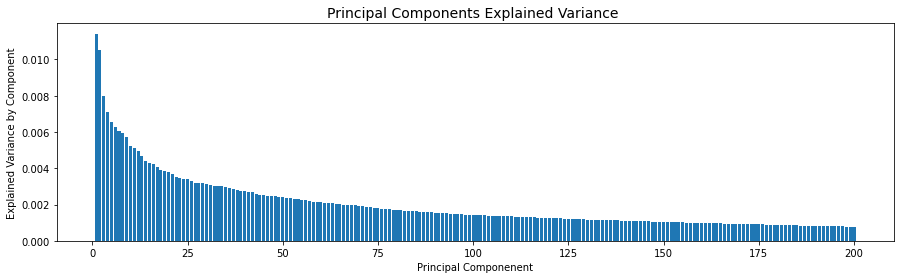

In [142]:
import matplotlib.pyplot as plt
num_components = list(range(1,201))

    
fig, axs = plt.subplots(figsize=(15,4))

plt.bar(num_components, explained_variance_list[4])
plt.title("Principal Components Explained Variance ", fontsize=14)
plt.xlabel("Principal Componenent")
plt.ylabel("Explained Variance by Component")




In [143]:
vec_matrix.shape

(20338, 8930)

In [106]:
sum(explained_variance_list[2])

0.20326217331087806

why did i choose k means 
why did i choose tsne 
why did i chosses SVD


How many words (dimensions are in the original vocabulary)

In [108]:
len(vecvocab)

8930